In [1]:
from platform import python_version

print(python_version())

3.9.19


In [16]:
#!wget https://s3.amazonaws.com/tripdata/JC-202301-citibike-tripdata.csv.zip
!wget https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD

--2024-04-01 23:29:18--  https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD
Resolving data.ct.gov (data.ct.gov)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.ct.gov (data.ct.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [     <=>            ] 113,24M  3,42MB/s    in 35s     

2024-04-01 23:29:53 (3,24 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [118737237]



In [ ]:
!unzip JC-202301-citibike-tripdata.csv.zip

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import io
import os
import requests
import pymysql
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
df = pd.read_csv("data/rows.csv")

/tmp/ipykernel_6622/3371070715.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/rows.csv")


In [21]:
display(df.head())

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
1,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family,NaN,NaN,NaN,NaN
2,210317,2021,07/05/2022,Avon,53 COTSWOLD WAY,329730.0,805000.0,0.4096,Residential,Single Family,NaN,NaN,NaN,POINT (-72.846365959 41.781677018)
3,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7248,Residential,Condo,NaN,NaN,NaN,NaN
4,200243,2020,04/13/2021,Avon,111 NORTHINGTON DRIVE,619290.0,890000.0,0.6958,Residential,Single Family,NaN,NaN,NaN,NaN


In [22]:
df.dtypes

Serial Number         int64
List Year             int64
Date Recorded        object
Town                 object
Address              object
Assessed Value      float64
Sale Amount         float64
Sales Ratio         float64
Property Type        object
Residential Type     object
Non Use Code         object
Assessor Remarks     object
OPM remarks          object
Location             object
dtype: object

In [2]:
dtypes = {
    "Serial Number": int,
    "List Year": int,
    "Town": str,
    "Address": str,
    "Assessed Value": float,
    "Sale Amount": float,
    "Sales Ratio": float,
    "Property Type": str,
    "Residential Type": str,
    "Non Use Code": str,
    "Assessor Remarks": str,
    "OPM remarks": str,
    "Location": str
        }

parse_dates = ['Date Recorded']

In [4]:
print(pd.io.sql.get_schema(df, name='real_state'))

CREATE TABLE "real_state" (
"Serial Number" INTEGER,
  "List Year" INTEGER,
  "Date Recorded" TEXT,
  "Town" TEXT,
  "Address" TEXT,
  "Assessed Value" REAL,
  "Sale Amount" REAL,
  "Sales Ratio" REAL,
  "Property Type" TEXT,
  "Residential Type" TEXT,
  "Non Use Code" TEXT,
  "Assessor Remarks" TEXT,
  "OPM remarks" TEXT,
  "Location" TEXT
)


In [27]:
url = "./data/rows.csv"
df_mod = pd.read_csv(url, sep=",", dtype=dtypes, parse_dates=parse_dates)

In [28]:
len(df_mod)

1054159

In [29]:
# Convert column names to lowercase
df_mod.columns = df_mod.columns.str.lower()

# Convert column names to snake case
df_mod.columns = df_mod.columns.str.replace(' ', '_')

In [30]:
df_mod.dtypes

serial_number                int64
list_year                    int64
date_recorded       datetime64[ns]
town                        object
address                     object
assessed_value             float64
sale_amount                float64
sales_ratio                float64
property_type               object
residential_type            object
non_use_code                object
assessor_remarks            object
opm_remarks                 object
location                    object
dtype: object

In [31]:
df_mod = df_mod.loc[:, ~df_mod.columns.isin(['serial_number', 'location', 'opm_remarks', 'assessor_remarks', 'non_use_code', 'date_recorded'])]

In [32]:
df_mod.dtypes

list_year             int64
town                 object
address              object
assessed_value      float64
sale_amount         float64
sales_ratio         float64
property_type        object
residential_type     object
dtype: object

In [45]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054159 entries, 0 to 1054158
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   list_year         1054159 non-null  int64  
 1   town              1054159 non-null  object 
 2   address           1054159 non-null  object 
 3   assessed_value    1054159 non-null  float64
 4   sale_amount       1054159 non-null  float64
 5   sales_ratio       1054159 non-null  float64
 6   property_type     1054159 non-null  object 
 7   residential_type  1054159 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 64.3+ MB


In [33]:
df_mod.describe()

,list_year,assessed_value,sale_amount,sales_ratio
count,1.054159e+06,1.054159e+06,1.054159e+06,1.054159e+06
mean,2.010774e+03,2.797416e+05,3.990286e+05,9.953241e+00
std,6.540711e+00,1.650117e+06,5.229758e+06,1.838434e+03
min,2.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.004000e+03,8.845000e+04,1.422000e+05,4.816008e-01
50%,2.011000e+03,1.395800e+05,2.300000e+05,6.162887e-01
75%,2.017000e+03,2.270000e+05,3.700000e+05,7.764000e-01
max,2.021000e+03,8.815100e+08,5.000000e+09,1.226420e+06


In [34]:
df_mod.isnull().sum()

list_year                0
town                     0
address                 51
assessed_value           0
sale_amount              0
sales_ratio              0
property_type       382446
residential_type    393884
dtype: int64

In [35]:
df_mod["residential_type"] = df_mod["residential_type"].fillna("NA")
df_mod["property_type"] = df_mod["property_type"].fillna("NA")
df_mod["address"] = df_mod["address"].fillna("NA")

In [36]:
df_mod.isnull().sum()

list_year           0
town                0
address             0
assessed_value      0
sale_amount         0
sales_ratio         0
property_type       0
residential_type    0
dtype: int64

In [37]:
select_value = 'Vacant Land'
result = df_mod[df_mod['property_type'] == select_value]

print(result.tail())

        list_year        town                 address  assessed_value  \
123778       2021   Waterford       15 NEW SHORE ROAD        103960.0   
123829       2021    Westport       LYONS PLAINS ROAD         32700.0   
123849       2021  Winchester  173 DANBURY QUARTER RD         40600.0   
123867       2021      Weston      50 BUTTONBALL LANE        365720.0   
123896       2021    Woodbury      69 BACON POND ROAD         79590.0   

        sale_amount  sales_ratio property_type residential_type  
123778     275000.0     0.378000   Vacant Land               NA  
123829      25000.0     1.308000   Vacant Land               NA  
123849      47500.0     0.854737   Vacant Land               NA  
123867     625000.0     0.585100   Vacant Land               NA  
123896     360000.0     0.221000   Vacant Land               NA  


In [38]:
distinct_values = df_mod['property_type'].unique()
display(distinct_values)

array(['Commercial', 'Residential', 'Vacant Land', 'NA', 'Apartments',
       'Industrial', 'Public Utility', 'Condo', 'Two Family',
       'Three Family', 'Single Family', 'Four Family'], dtype=object)

In [39]:
distinct_values = df_mod['list_year'].unique()
display(distinct_values)

array([2020, 2021, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [41]:
table = pa.Table.from_pandas(df_mod)

In [42]:
# Define the Parquet file path
parquet_path = './data/parquet/'

In [43]:
# Write partitioned Parquet file
pq.write_to_dataset(table, root_path=parquet_path)


In [44]:
df_parq = pd.read_parquet("data/parquet/9d6f6fa8770d4bf889632f4d3cc65ec5-0.parquet")
df_parq.head()

,list_year,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type
0,2020,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NA
1,2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family
2,2021,Avon,53 COTSWOLD WAY,329730.0,805000.0,0.4096,Residential,Single Family
3,2020,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7248,Residential,Condo
4,2020,Avon,111 NORTHINGTON DRIVE,619290.0,890000.0,0.6958,Residential,Single Family


In [59]:
def formatar_numero(numero):
    return '{:,.2f}'.format(numero)

# Aplica a função de formatação aos valores das vendas
pd.options.display.float_format = formatar_numero

In [61]:
soma_vendas_por_ano = df_parq.groupby('list_year')['sale_amount'].sum()

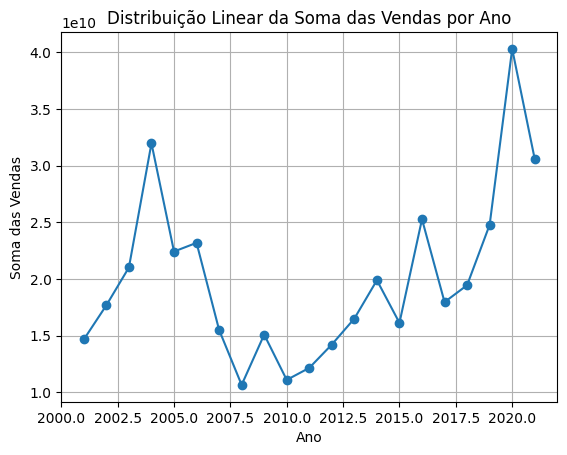

In [62]:
plt.plot(soma_vendas_por_ano.index, soma_vendas_por_ano.values, marker='o')
# Adicionar rótulos e título
plt.xlabel('Ano')
plt.ylabel('Soma das Vendas')
plt.title('Distribuição Linear da Soma das Vendas por Ano')
# Mostrar o gráfico
plt.grid(True)
plt.show()

In [63]:
yearly_sales = df_parq.groupby('list_year')['sale_amount'].sum()
print("\nDistribuição de vendas por ano:")
print(yearly_sales)


Distribuição de vendas por ano:
list_year
2001   14,671,668,335.00
2002   17,687,185,857.00
2003   21,020,152,793.00
2004   31,966,245,823.00
2005   22,424,983,827.00
2006   23,191,375,510.40
2007   15,518,803,446.00
2008   10,666,103,724.00
2009   15,100,980,907.00
2010   11,107,540,414.00
2011   12,167,673,424.00
2012   14,226,518,439.22
2013   16,517,079,160.00
2014   19,895,675,672.67
2015   16,135,823,472.00
2016   25,272,800,660.00
2017   17,968,045,819.66
2018   19,458,446,161.20
2019   24,778,187,646.50
2020   40,285,754,101.02
2021   30,578,589,572.46
Name: sale_amount, dtype: float64


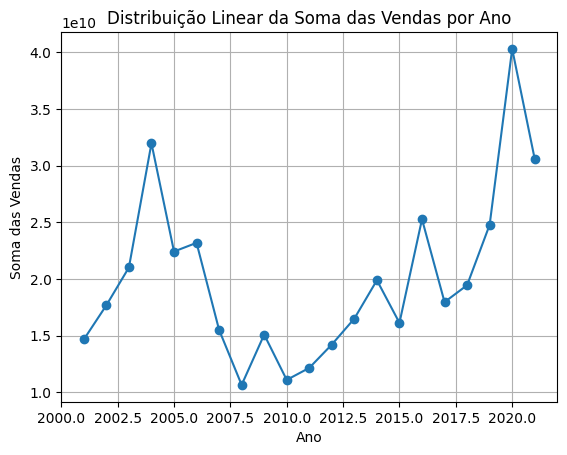

In [64]:
plt.plot(yearly_sales.index, yearly_sales.values, marker='o')
# Adicionar rótulos e título
plt.xlabel('Ano')
plt.ylabel('Soma das Vendas')
plt.title('Distribuição Linear da Soma das Vendas por Ano')
# Mostrar o gráfico
plt.grid(True)
plt.show()

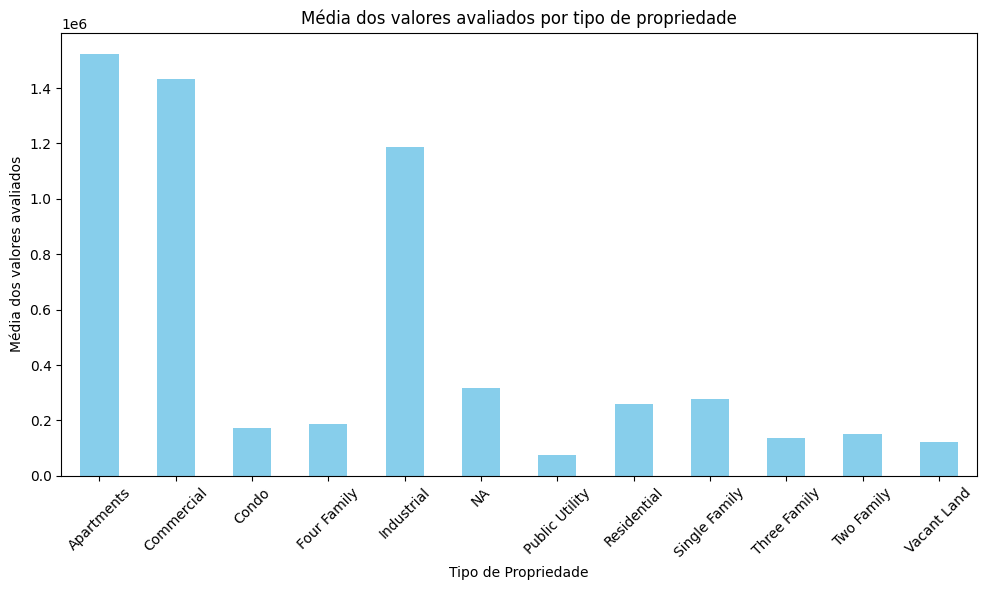

In [65]:
# Agrupar os dados por property_type e calcular a média dos valores avaliados
mean_values_by_property_type = df_parq.groupby('property_type')['assessed_value'].mean()

# Criar o gráfico de barras
mean_values_by_property_type.plot(kind='bar', color='skyblue', figsize=(10, 6))

# Personalizar o gráfico
plt.title('Média dos valores avaliados por tipo de propriedade')
plt.xlabel('Tipo de Propriedade')
plt.ylabel('Média dos valores avaliados')
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x para melhor legibilidade

# Mostrar o gráfico
plt.tight_layout()
plt.show()

/tmp/ipykernel_207259/464750751.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


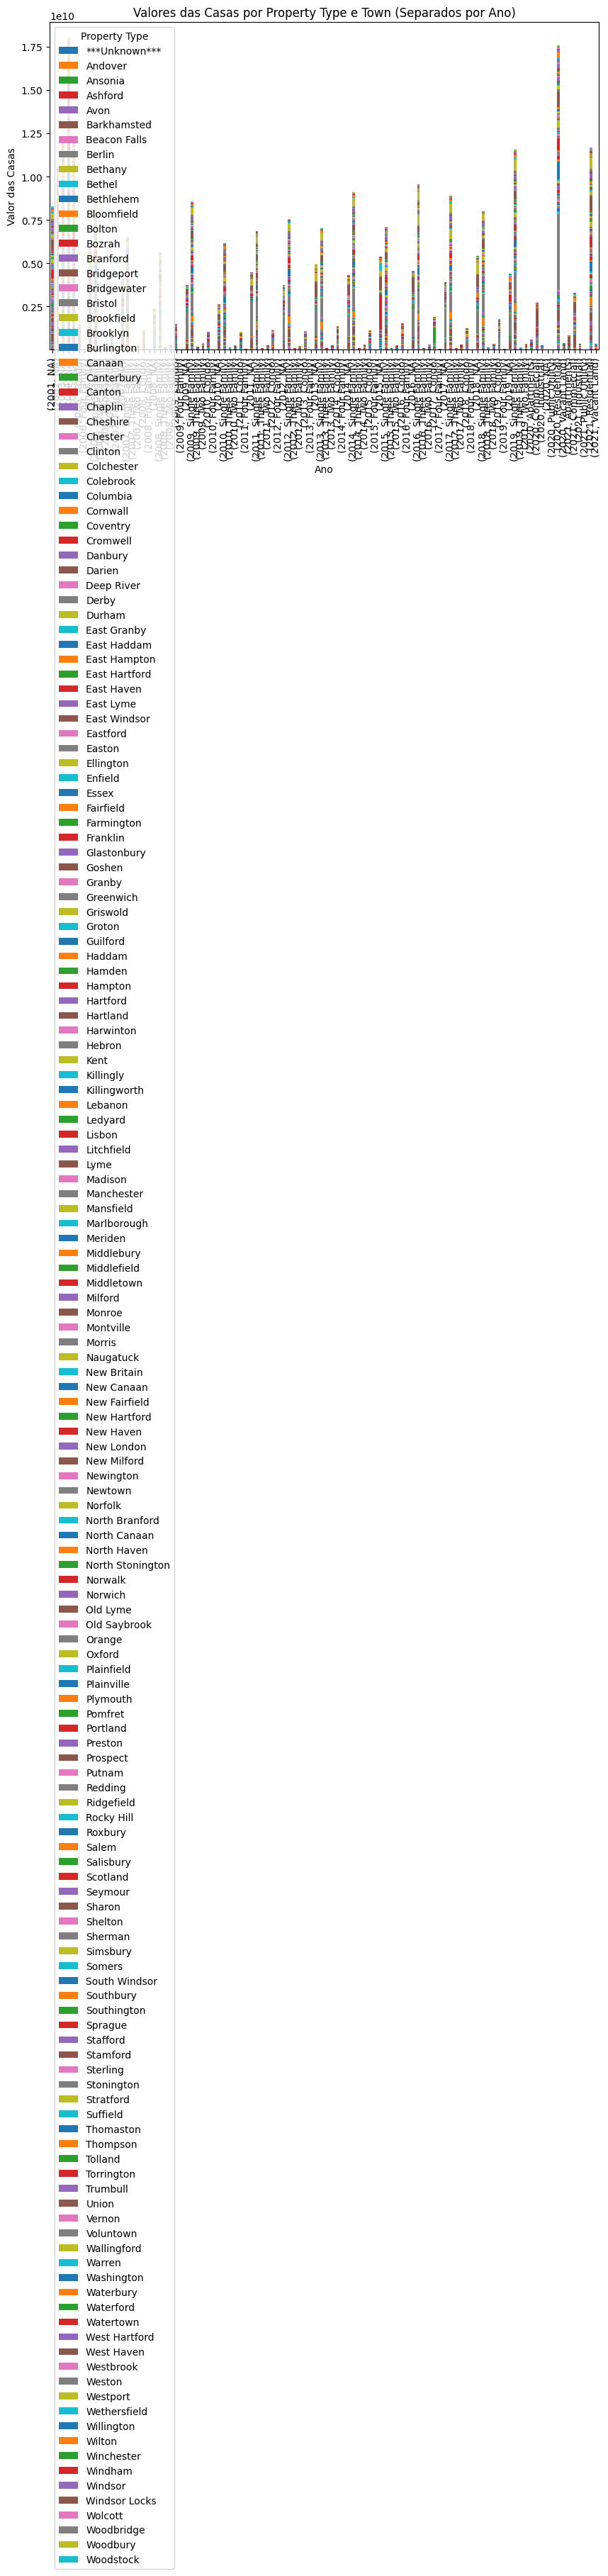

In [67]:
# Criar gráfico de barras empilhadas
fig, ax = plt.subplots(figsize=(10, 6))

# Agrupar dados por ano, tipo de propriedade e cidade
grouped = df_parq.groupby(['list_year', 'property_type', 'town']).sum()['assessed_value'].unstack()

# Plotar gráfico de barras empilhadas
grouped.plot(kind='bar', stacked=True, ax=ax)

# Personalizar o gráfico
ax.set_title('Valores das Casas por Property Type e Town (Separados por Ano)')
ax.set_ylabel('Valor das Casas')
ax.set_xlabel('Ano')

# Mostrar legenda
ax.legend(title='Property Type', loc='upper left')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

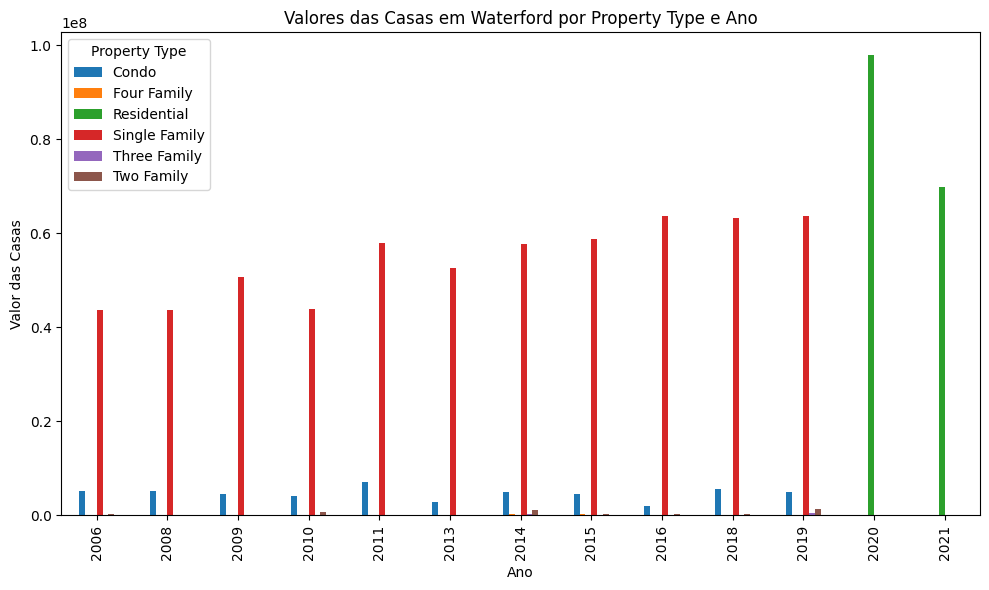

In [70]:
# Filtrar os dados para uma cidade específica e excluir valores NA
city = 'Waterford'
filtered_df = df_parq[(df_parq['town'] == city) & (df_parq['residential_type'] != 'NA')]

# Criar gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Agrupar dados por ano e tipo de propriedade
grouped = filtered_df.groupby(['list_year', 'property_type']).sum()['assessed_value'].unstack()

# Plotar gráfico de barras
grouped.plot(kind='bar', ax=ax)

# Personalizar o gráfico
ax.set_title(f'Valores das Casas em {city} por Property Type e Ano')
ax.set_ylabel('Valor das Casas')
ax.set_xlabel('Ano')

# Mostrar legenda
ax.legend(title='Property Type')

# Mostrar o gráfico
plt.tight_layout()
plt.show()